In [117]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, mean_squared_error, r2_score
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
def process_data(caminho_features, caminho_subject, caminho_X, tipo='train'):
    # Carregar features.txt em uma Series
    features_df = pd.read_csv('/content/features.txt', delim_whitespace=True, header=None, usecols=[1])
    features = features_df.squeeze()
    features.name = 'Var'

    # Carregar subject_train.txt ou subject_test.txt em uma Series
    subject_df = pd.read_csv('/content/subject_train.txt', header=None)
    subject = subject_df.squeeze()
    subject.name = 'subject'

    # Carregar X_train.txt ou X_test.txt em um DataFrame
    X = pd.read_csv('/content/X_train.txt', header=None, sep=" ", skipinitialspace=True)

    # Renomear as colunas de X usando os nomes em features
    X.columns = features

    # Adicionar o identificador do sujeito como uma nova coluna no DataFrame
    X = X.assign(individuo=subject)

    # Criar um índice duplo usando a ordem dos dados e o identificador do sujeito
    X = X.set_index([X.index, 'individuo'])
    X.index = X.index.set_names(['indice', 'individuo'])

    # Selecionar apenas as três primeiras colunas de interesse
    X_selected = X[['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z']]

    # Salvar os DataFrames em arquivos CSV
    X.to_csv(f"./output/X_{tipo}.csv", index=True)
    X_selected.to_csv(f"./output/X_{tipo}_selected.csv", index=True)

    return X, X_selected

In [3]:
# Caminhos dos arquivos (substitua pelos caminhos corretos)
caminho_features = 'input/features.txt'
caminho_subject_train = 'input/subject_train.txt'
caminho_X_train = 'input/X_train.txt'
caminho_subject_test = 'input/subject_test.txt'
caminho_X_test = 'input/X_test.txt'

In [4]:
# Processar e salvar os dados de treino
X_train, X_train_selected = process_data(caminho_features, caminho_subject_train, caminho_X_train, tipo='train')

<ipython-input-2-21bd63125320>:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  features_df = pd.read_csv('/content/features.txt', delim_whitespace=True, header=None, usecols=[1])


In [5]:
# Processar e salvar os dados de teste
X_test, X_test_selected = process_data(caminho_features, caminho_subject_test, caminho_X_test, tipo='test')

<ipython-input-2-21bd63125320>:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  features_df = pd.read_csv('/content/features.txt', delim_whitespace=True, header=None, usecols=[1])


In [6]:
# Exibir os DataFrames finais selecionados
X_train_selected.head()

,Var,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z
indice,individuo,,,
0,1,0.288585,-0.020294,-0.132905
1,1,0.278419,-0.016411,-0.123520
2,1,0.279653,-0.019467,-0.113462
3,1,0.279174,-0.026201,-0.123283
4,1,0.276629,-0.016570,-0.115362


In [7]:
# Carregar os dados selecionados (três primeiras colunas + subject)
X_train_selected = pd.read_csv("/content/output/X_train_selected.csv", index_col=[0, 1])
X_test_selected = pd.read_csv("/content/output/X_test_selected.csv", index_col=[0, 1])

In [13]:
# Renomeando a coluna 'antigo_nome' para 'novo_nome'
X_train_selected.rename(columns={'tBodyAcc-mean()-Y': 'subject'}, inplace=True)

print(X_train_selected)

                  tBodyAcc-mean()-X   subject  tBodyAcc-mean()-Z
indice individuo                                                
0      1                   0.288585 -0.020294          -0.132905
1      1                   0.278419 -0.016411          -0.123520
2      1                   0.279653 -0.019467          -0.113462
3      1                   0.279174 -0.026201          -0.123283
4      1                   0.276629 -0.016570          -0.115362
...                             ...       ...                ...
7347   30                  0.299665 -0.057193          -0.181233
7348   30                  0.273853 -0.007749          -0.147468
7349   30                  0.273387 -0.017011          -0.045022
7350   30                  0.289654 -0.018843          -0.158281
7351   30                  0.351503 -0.012423          -0.203867

[7352 rows x 3 columns]


In [15]:
# Atribuir as features e o target
X_train = X_train_selected[['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Z']]
y_train = X_train_selected['subject']

In [16]:
y_train.head()

,,subject
indice,individuo,
0,1,-0.020294
1,1,-0.016411
2,1,-0.019467
3,1,-0.026201
4,1,-0.016570


In [17]:
# Renomeando a coluna 'antigo_nome' para 'novo_nome'
X_test_selected.rename(columns={'tBodyAcc-mean()-Y': 'subject'}, inplace=True)

print(X_test_selected)

                  tBodyAcc-mean()-X   subject  tBodyAcc-mean()-Z
indice individuo                                                
0      1                   0.288585 -0.020294          -0.132905
1      1                   0.278419 -0.016411          -0.123520
2      1                   0.279653 -0.019467          -0.113462
3      1                   0.279174 -0.026201          -0.123283
4      1                   0.276629 -0.016570          -0.115362
...                             ...       ...                ...
7347   30                  0.299665 -0.057193          -0.181233
7348   30                  0.273853 -0.007749          -0.147468
7349   30                  0.273387 -0.017011          -0.045022
7350   30                  0.289654 -0.018843          -0.158281
7351   30                  0.351503 -0.012423          -0.203867

[7352 rows x 3 columns]


In [18]:
# Atribuir as features e o target
X_test = X_test_selected[['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Z']]
y_test = X_test_selected['subject']

In [57]:
y_test.head()

,,subject
indice,individuo,
0,1,-0.020294
1,1,-0.016411
2,1,-0.019467
3,1,-0.026201
4,1,-0.016570


In [23]:
# Use DecisionTreeRegressor para variáveis ​​de destino contínuas
tree = DecisionTreeRegressor(min_samples_leaf=20, random_state=42)
tree.fit(X_train, y_train)

DecisionTreeRegressor(min_samples_leaf=20, random_state=42)

In [24]:
# 2.2 Calcular os ccp_alphas
path = tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas


In [25]:
# Garantir que os valores de ccp_alpha sejam positivos e únicos
ccp_alphas = np.unique(ccp_alphas[ccp_alphas > 0])

In [26]:
# 2.3 Selecionar 1 a cada 5 valores de ccp_alpha
ccp_alphas = ccp_alphas[::5]

In [28]:
# 3.1 Rodar uma árvore para cada ccp_alpha e salvar em uma lista
trees = []
for ccp_alpha in ccp_alphas:
    # Use DecisionTreeRegressor para variáveis de destino contínuas
    tree = DecisionTreeRegressor(random_state=42, ccp_alpha=ccp_alpha)
    tree.fit(X_train, y_train)
    trees.append(tree)

In [29]:
# 3.2 Calcular a acurácia de cada árvore na base de treinamento e de teste
train_scores = [tree.score(X_train, y_train) for tree in trees]
test_scores = [tree.score(X_test, y_test) for tree in trees]

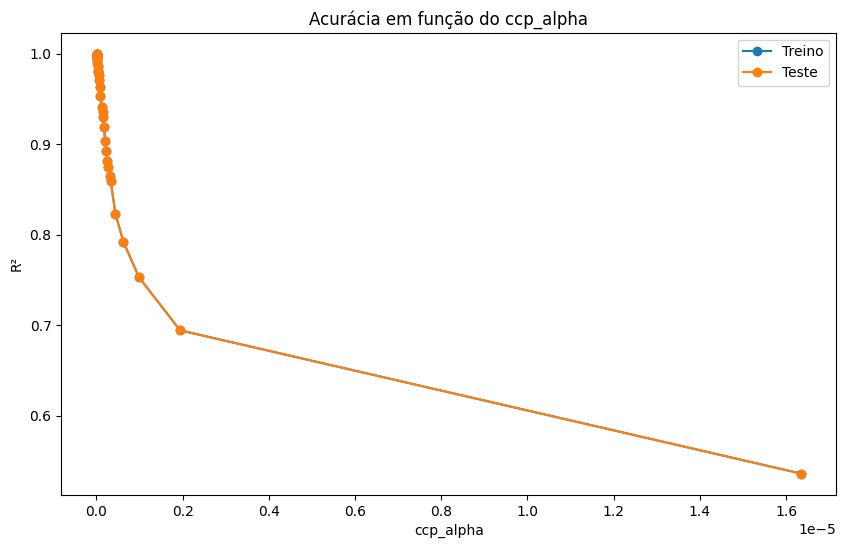

In [30]:
# 3.3 Montar um gráfico da acurácia em função do ccp_alpha na base de validação e na base de teste
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, train_scores, marker='o', label='Treino')
plt.plot(ccp_alphas, test_scores, marker='o', label='Teste')
plt.xlabel('ccp_alpha')
plt.ylabel('R²')
plt.title('Acurácia em função do ccp_alpha')
plt.legend()
plt.show()

In [31]:
# 3.4 Selecionar a melhor árvore com melhor acurácia na base de teste
best_index = np.argmax(test_scores)
best_tree = trees[best_index]

In [32]:
# 3.5 Melhor acurácia na base de teste
best_accuracy = test_scores[best_index]
print(f'Melhor acurácia na base de teste: {best_accuracy:.4f}')

Melhor acurácia na base de teste: 1.0000


**✈**

In [34]:
#
validation_X_train = X_train.sample(frac=0.25, random_state=42)  # 25% da base de treino
train_df = X_train.drop(validation_X_train.index)  # Remover a base de validação da base de treino

In [36]:
# Criar e treinar a árvore de decisão
clf = DecisionTreeRegressor(max_depth=4, random_state=42) # Changed to DecisionTreeRegressor
clf.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4, random_state=42)

In [37]:
# Obter a importância das variáveis
importances = clf.feature_importances_

In [39]:
# Ensure that X is defined and holds the expected DataFrame of features
importance_df = pd.DataFrame({'feature': X_train.columns, 'importance': importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)

In [40]:
# Criar um DataFrame para visualizar a importância
importance_df = pd.DataFrame({'feature': X_train.columns, 'importance': importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)

In [41]:
# Selecionar as 3 variáveis com maior importância
top_features = importance_df.head(3)
print(top_features)

             feature  importance
0  tBodyAcc-mean()-X    0.691997
1  tBodyAcc-mean()-Z    0.308003


In [42]:
# Extract the column names from top_features DataFrame
top_features_list = top_features['feature'].tolist()

In [43]:
print(top_features)

             feature  importance
0  tBodyAcc-mean()-X    0.691997
1  tBodyAcc-mean()-Z    0.308003


In [44]:
# Filtrar o DataFrame para incluir apenas as 3 variáveis
X_train_top = X_train[top_features_list]
X_val_top = X_test[top_features_list]

Melhor ccp_alpha: 0.0, MSE: 0.0
MSE na base de teste: 0.0


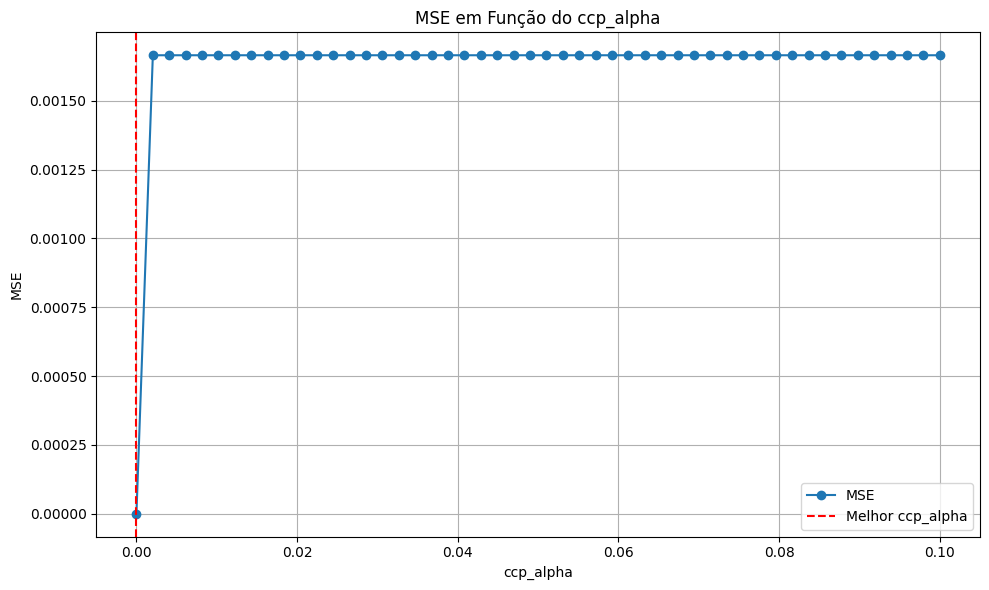

In [60]:
# Valores de ccp_alpha a serem testados
ccp_alphas = np.linspace(0, 0.1, 50)
best_alpha = None
best_mse = float('inf')  # Inicialize com um valor grande para MSE
best_clf = None  # Inicialize best_clf aqui

# Lista para armazenar os valores de MSE
mse_values = []  # Inicialize uma lista vazia para armazenar os MSEs

# Iterar sobre os valores de ccp_alpha
for alpha in ccp_alphas:
    # Usar DecisionTreeRegressor para variável de destino contínua
    clf = DecisionTreeRegressor(ccp_alpha=alpha, random_state=42)

    # Treinar o modelo
    clf.fit(X_train_top, y_train)

    # Fazer previsões na base de validação
    y_val_pred = clf.predict(X_val_top)

    # Calcular o erro quadrático médio (MSE)
    mse = mean_squared_error(y_train, y_val_pred) # Corrigido para y_val_pred

    # Armazenar o MSE na lista
    mse_values.append(mse)

    # Atualizar o melhor MSE e o melhor alpha
    if mse < best_mse:
        best_mse = mse
        best_alpha = alpha
        best_clf = clf

# Exibir o melhor alpha e o MSE
print(f'Melhor ccp_alpha: {best_alpha}, MSE: {best_mse}')

# Fazer previsões na base de testes
y_test_pred = best_clf.predict(X_test)  # Corrigido para X_test

# Se desejar calcular o MSE na base de teste
mse_test = mean_squared_error(y_test, y_test_pred)
print(f'MSE na base de teste: {mse_test}')

# Gráfico do MSE em função de ccp_alpha
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, mse_values, marker='o', label='MSE') # mse_values agora está definido
plt.axvline(x=best_alpha, color='r', linestyle='--', label='Melhor ccp_alpha')
plt.xlabel('ccp_alpha')
plt.ylabel('MSE')
plt.title('MSE em Função do ccp_alpha')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

**✈**

In [62]:
# Use DecisionTreeRegressor para variável de destino contínua
clf = DecisionTreeRegressor(min_samples_leaf=20, random_state=42)
clf.fit(X_train_top, y_train)

DecisionTreeRegressor(min_samples_leaf=20, random_state=42)

In [63]:
print(top_features)

             feature  importance
0  tBodyAcc-mean()-X    0.691997
1  tBodyAcc-mean()-Z    0.308003


In [64]:
print(X_test.columns)

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Z'], dtype='object')


In [66]:
# Supondo que X_test sejam seus dados de teste originais e 'top_features' seja uma lista de recursos
X_test_top = X_test_selected['tBodyAcc-mean()-X']

In [67]:
X_test_selected.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7352 entries, (0, 1) to (7351, 30)
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tBodyAcc-mean()-X  7352 non-null   float64
 1   subject            7352 non-null   float64
 2   tBodyAcc-mean()-Z  7352 non-null   float64
dtypes: float64(3)
memory usage: 510.1 KB


In [71]:
# Avaliar usando métricas de regressão, como MSE ou R-squared
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print(f'Erro Quadrático Médio (MSE) na base de testes: {mse}')
print(f'R-squared (R2) na base de testes: {r2}')

Erro Quadrático Médio (MSE) na base de testes: 0.0
R-squared (R2) na base de testes: 1.0


In [83]:
# Exemplo de discretização:
num_bins = 5  # Número de bins para discretização
y_test_binned = np.digitize(y_test, np.linspace(min(y_test), max(y_test), num_bins))
y_test_pred_binned = np.digitize(y_test_pred, np.linspace(min(y_test_pred), max(y_test_pred), num_bins))

# Agora você pode usar classification_report com os dados discretizados:
class_report = classification_report(y_test_binned, y_test_pred_binned)
print('Relatório de Classificação (Discretizado):')
print(class_report)

Relatório de Classificação (Discretizado):
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00      6392
           3       1.00      1.00      1.00       949
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         1

    accuracy                           1.00      7352
   macro avg       1.00      1.00      1.00      7352
weighted avg       1.00      1.00      1.00      7352



In [86]:
# Definir os valores de ccp_alpha
ccp_alphas = np.linspace(0, 0.1, 100)  # 100 valores de ccp_alpha
ccp_alphas = ccp_alphas[::10]  # Selecionar 1 a cada 10 valores

In [87]:
# Inicializar variáveis para armazenar resultados
best_alpha = None
best_score = 0

In [90]:
# Medir o tempo
start_time = time.time()

In [97]:
# K-Fold Cross Validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize best_score with a very low value to ensure it's updated
best_score = -float('inf')  # or any very large negative number

for alpha in ccp_alphas:
    # Use DecisionTreeRegressor for continuous target variables
    clf = DecisionTreeRegressor(ccp_alpha=alpha, min_samples_leaf=20, random_state=42)

    # Change scoring to a regression metric, such as 'neg_mean_squared_error'
    scores = cross_val_score(clf, X_test, y_test, cv=kf, scoring='neg_mean_squared_error')

    mean_score = scores.mean()

    if mean_score > best_score:
        best_score = mean_score
        best_alpha = alpha

In [98]:
# Medir o tempo final
end_time = time.time()
elapsed_time = end_time - start_time

print(f'Melhor ccp_alpha: {best_alpha}, Acurácia média: {best_score}')
print(f'Tempo de execução: {elapsed_time:.2f} segundos')

Melhor ccp_alpha: 0.0101010101010101, Acurácia média: -0.0016659926600559771
Tempo de execução: 184.01 segundos


In [101]:
# Use DecisionTreeRegressor para variáveis ​​de destino contínuas
best_clf = DecisionTreeRegressor(ccp_alpha=best_alpha, min_samples_leaf=20, random_state=42)
best_clf.fit(X_train[top_features_list], y_train)  # Treinar em toda a base de treino

DecisionTreeRegressor(ccp_alpha=0.0101010101010101, min_samples_leaf=20,
                      random_state=42)

In [108]:
# Fazer previsões na base de testes
y_test_pred = best_clf.predict(X_test[top_features_list])

# Calcular o R-squared
r2 = r2_score(y_test, y_test_pred)
print(f'R-squared na base de testes: {r2}')

# Calcular o Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_test_pred)
print(f'Mean Squared Error (MSE) na base de testes: {mse}')

R-squared na base de testes: 0.0
Mean Squared Error (MSE) na base de testes: 0.0016652723790956559


In [114]:
# Calcular o Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_test_pred)
print(f'Mean Absolute Error (MAE) na base de testes: {mae}')

Mean Absolute Error (MAE) na base de testes: 0.016277085037731807


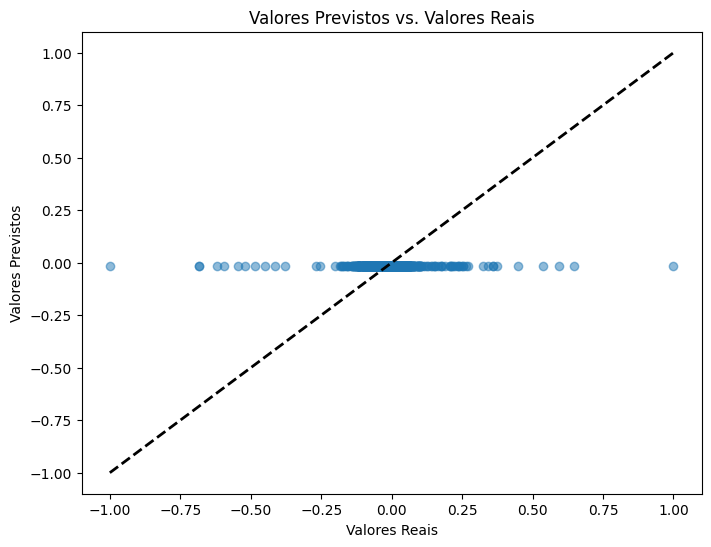

In [124]:
# Visualize valores previstos versus valores reais (gráfico de dispersão)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valores Reais')
plt.ylabel('Valores Previstos')
plt.title('Valores Previstos vs. Valores Reais')
plt.show()

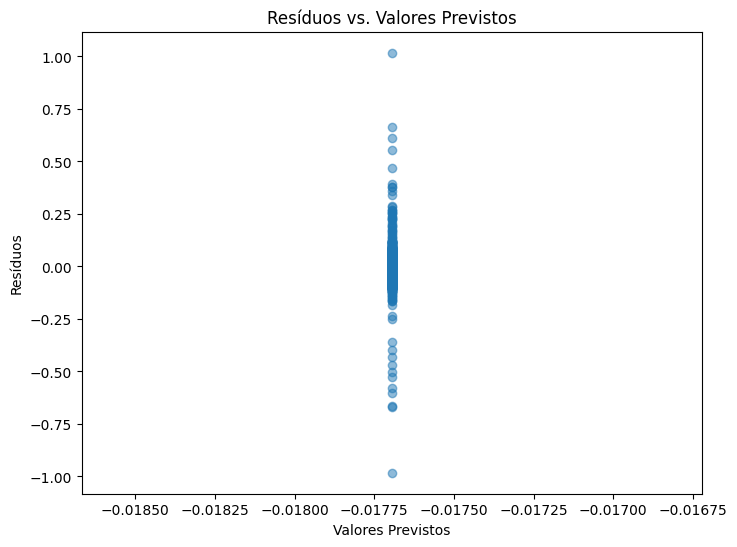

In [122]:
# Opcionalmente, visualize resíduos
residuals = y_test - y_test_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.hlines(y=0, xmin=y_test_pred.min(), xmax=y_test_pred.max(), colors='k', linestyles='--', lw=2)
plt.xlabel('Valores Previstos')
plt.ylabel('Resíduos')
plt.title('Resíduos vs. Valores Previstos')
plt.show()